In [1]:
import os
import re
import sys
print(f'Python: {sys.prefix}')
import time
import shutil
import copy
import glob
import numpy as np
import itertools
import importlib
import multiprocessing
import segyio
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy import signal, ndimage
from natsort import natsorted
# import shared as sd
# import loaders as ld
# import vis
from utils import shared as sd
from utils import loaders as ld
from utils import vis
from IPython.display import clear_output
print(os.getcwd())
# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../codes_server'))
sys.path.append(os.path.abspath('./utils'))
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
api._cmd(('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh'))
import m8r as sf

Python: /home/plotnips/anaconda3/envs/lw


/tmp/ipykernel_45745/2123174083.py:15: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
source /home/plotnips/Madagascar/share/madagascar/etc/env.sh


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 100,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [3]:
# root_out = '/home/ovcharoo/work/data/'
# root_field = os.path.join('../data_cgg/')
# root_out = '/home/ovcharoo/work/data/'
root_field='./data_cgg'

In [4]:
# Time sampling in ML application
dt_net = 0.016

In [5]:
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

def divmax(x): return x / np.max(np.abs(x))
    
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp

def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)
    return ax

def plot_logs(m1, m2, idx=2, title=''):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 

# Load initial model

Load ./data_cgg/cgg_tomo.hh
	dim: 2
	dict['n1'] <-- n1 <-- 300
	dict['d1'] <-- d1 <-- 12.5
	dict['o1'] <-- o1 <-- 0
	dict['n2'] <-- n2 <-- 1000
	dict['d2'] <-- d2 <-- 12.5
	dict['o2'] <-- o2 <-- 0
	data <-- (300, 1000)
2 (142, 500)
3 (152, 500)
4 (152, 500)
5 (152, 500)
(152, 600)
nz0=152, nx0=600
(152, 600)
1490.0
(152, 600)


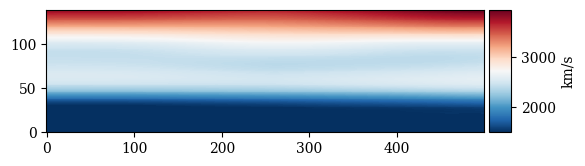

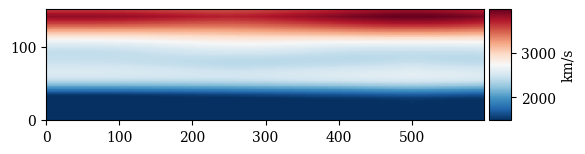

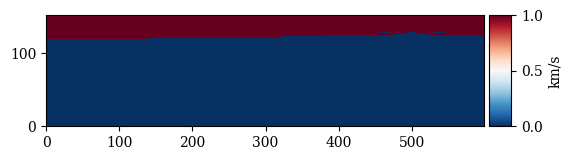

In [6]:
dx = 12.5
vp, _ = ld.load_hh(os.path.join(root_field, 'cgg_tomo.hh'), 1)
vp = np.flipud(vp.T)[::1, ::1] * 1000

# Downsample
factor = 2
ndown = 10
dx = dx * factor
vp = vp[::factor, ::factor]
vp = vp[:-ndown, :]

vis.plot_model(np.flipud(vp))
# print(vp.shape)

def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x

ndeeper = 2
nexp = 100
vp_cgg = extend(vp, ndeeper, 0)
print('2',vp_cgg.shape)
vp_cgg = np.concatenate((np.flip(vp_cgg[:ndown, :], 0), vp_cgg), 0)  # OZ
print('3',vp_cgg.shape)
vp_cgg = np.where(vp_cgg < 1490.0, 1490.0, vp_cgg)
print('4',vp_cgg.shape)
tmp = extend(vp_cgg, 0,nexp)
print('5',vp_cgg.shape)
print(tmp.shape)

# taper0 = tmp[:,:500] < 1.01 * np.min(tmp[:,:500])
taper0 = tmp < 1.01 * np.min(tmp)


# tmp = extend(vp, ndeeper, 0)
# print(tmp.shape)
vis.plot_model(np.flipud(tmp))
vis.plot_model(taper0)
vp = tmp.copy()
nz0, nx0 = vp.shape
print(f'nz0={nz0}, nx0={nx0}')
print(taper0.shape)
print(vp_cgg.min())
print(vp.shape)

# Well-log model

Load ./data_cgg/cgg_log.hh
	dim: 2
	dict['n1'] <-- n1 <-- 241
	dict['d1'] <-- d1 <-- 12.5
	dict['o1'] <-- o1 <-- 0
	dict['n2'] <-- n2 <-- 800
	dict['d2'] <-- d2 <-- 12.5
	dict['o2'] <-- o2 <-- 0
	data <-- (241, 800)
0= (800, 241)
(116, 600)


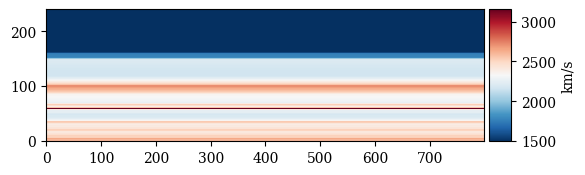

In [7]:
lvp, _ = ld.load_hh(os.path.join(root_field, 'cgg_log.hh'), 1)
print('0=',lvp.shape)
lvp = np.flipud(lvp.T)
vis.plot_model(lvp)

lvp = lvp[::factor, :]
lvp = lvp[:-5, :nx0]
print(lvp.shape)

# shear velocity, [m/s]
lvs = lvp.copy() / (3 ** 0.5)
lvs = np.where(lvp < 1.01 * np.min(lvp), 0, lvs)

# density, [kg/m3] 
lrho = 1e3*0.3 * lvp.copy()**0.25
lrho = np.where(lvp < 1.01 * np.min(lvp), 1000, lrho)
model_log = api.Model(lvp, lvs, lrho, dx)

log_loc = 10500 # m
log_idx = int(log_loc / dx)
# plot_logs(model_log, vp_cgg, log_idx, title='Initial vs well-log')

In [8]:
# # model = api.Model(vp, vs, rho, dx)
# model = copy.deepcopy(model_cgg)
# print(model)
# nz, nx = vp.shape
# vplim = {'vmax': model.vp.max()/1000, 'vmin': model.vp.min()/1000}
# vslim = {'vmax': model.vs.max()/1000, 'vmin': model.vs.min()/1000}
# rholim = {'vmax': model.rho.max()/1000, 'vmin': model.rho.min()/1000}
# vlims = {'vp': vplim, 'vs': vslim, 'rho': rholim}
# print(f'size:\t{(nz,nx)}\nvp:\t{vplim}\nvs:\t{vslim}\nrho:\t{rholim}')

# Data

In [9]:
# filename = '/home/ovcharoo/Dropbox/swag_datasets/CGG_NW_Australia/bdata.segy'
filename = '../CGG_NW_Australia/bdata.segy'

In [10]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df

def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [11]:
import pickle
def save_object(obj, filename):
    print(f'Save obj to {filename}')
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
# Parsing 15 Gb data, takes some time!
hname = os.path.join(root_field, 'trace_headers.pkl')
trace_headers = sd.load_object(hname)

# if trace_headers is None:
#     t1 = time.time()
#     with segyio.open(filename, ignore_geometry=True) as f:
#         # Get basic attributes
#         n_traces = f.tracecount
#     #     sample_rate = segyio.tools.dt(f) / 1000
#     #     n_samples = f.samples.size
#     #     twt = f.samples
#     #     data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
#         # Load headers
#         bin_headers = f.bin
#     #     text_headers = parse_text_header(f)
#         trace_headers = parse_trace_headers(f, n_traces)

if trace_headers is None:
    t1 = time.time()
    with segyio.open(filename, ignore_geometry=True) as f:
        n_traces = f.tracecount
#         n_traces=100
        trace_headers = parse_trace_headers(f,n_traces)
    save_object(trace_headers, hname)
    print(f'Elapsed time: {time.time() - t1} sec')

Load obj from ./data_cgg/trace_headers.pkl


Creating a segy file is a headache. Have to fill in filelds in segyio.spec() to send it as second argument in segyio.create(fname, spec)

In [12]:
with segyio.open(filename, ignore_geometry=True) as f:
    print('\n'.join([str(s) for s in [f.sorting, 
                                      f.format, 
                                      f.samples.shape,
                                     f.ilines,
                                     f.xlines,
                                     f.tracecount,
#                                      f.text[0],
                                     f.header]]))

None
4-byte IBM float
(3526,)
None
None
1181952


In [13]:
# header for whole dataset
# bin_headers

In [14]:
# header of each trace
trace_headers.head()

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit,UnassignedInt1,UnassignedInt2
1,1,1,785,1,0,2685,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,2,785,2,0,2686,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,3,785,3,0,2687,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,4,785,4,0,2688,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,5,5,785,5,0,2689,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# list keys in header
trace_headers.keys()

Index(['TRACE_SEQUENCE_LINE', 'TRACE_SEQUENCE_FILE', 'FieldRecord',
       'TraceNumber', 'EnergySourcePoint', 'CDP', 'CDP_TRACE',
       'TraceIdentificationCode', 'NSummedTraces', 'NStackedTraces', 'DataUse',
       'offset', 'ReceiverGroupElevation', 'SourceSurfaceElevation',
       'SourceDepth', 'ReceiverDatumElevation', 'SourceDatumElevation',
       'SourceWaterDepth', 'GroupWaterDepth', 'ElevationScalar',
       'SourceGroupScalar', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'CoordinateUnits', 'WeatheringVelocity', 'SubWeatheringVelocity',
       'SourceUpholeTime', 'GroupUpholeTime', 'SourceStaticCorrection',
       'GroupStaticCorrection', 'TotalStaticApplied', 'LagTimeA', 'LagTimeB',
       'DelayRecordingTime', 'MuteTimeStart', 'MuteTimeEND',
       'TRACE_SAMPLE_COUNT', 'TRACE_SAMPLE_INTERVAL', 'GainType',
       'InstrumentGainConstant', 'InstrumentInitialGain', 'Correlated',
       'SweepFrequencyStart', 'SweepFrequencyEnd', 'SweepLength', 'SweepType',
       'Swee

In [16]:
# Drop empty columns
th = trace_headers.loc[:, (trace_headers != 0).any(axis=0)]
th = th.loc[:, (trace_headers != 1).any(axis=0)]
th = th.drop(['TRACE_SEQUENCE_LINE', 'CDP_X', 
              'CDP_Y', 'CDP', 'INLINE_3D', 
              'CROSSLINE_3D', 'FieldRecord'], axis=1)
print(f'Drop empty cols! {len(trace_headers.keys())} --> {len(th.keys())}')

Drop empty cols! 91 --> 13


In [17]:
th.head()

,TRACE_SEQUENCE_FILE,TraceNumber,offset,SourceWaterDepth,GroupWaterDepth,SourceX,SourceY,GroupX,GroupY,MuteTimeStart,MuteTimeEND,TRACE_SAMPLE_COUNT,TRACE_SAMPLE_INTERVAL
1,1,1,169,50,80,269150,7771352,269296,7771267,0,0,3526,2000
2,2,2,181,50,81,269150,7771352,269307,7771262,0,0,3526,2000
3,3,3,194,50,83,269150,7771352,269319,7771257,0,0,3526,2000
4,4,4,206,50,85,269150,7771352,269330,7771252,0,0,3526,2000
5,5,5,219,50,87,269150,7771352,269342,7771247,0,0,3526,2000


In [18]:
# Convert depths to meters (multiplied by 10 by default)
th[['SourceWaterDepth', 'GroupWaterDepth']] = th[['SourceWaterDepth', 'GroupWaterDepth']].divide(10.)
# Init TraceNumber (rec id within a shot gather) to start from 0 rather form 1
th['TraceNumber'] = th['TraceNumber'].sub(1)
th['TRACE_SEQUENCE_FILE'] = th['TRACE_SEQUENCE_FILE'].sub(1)

In [19]:
th.describe()

,TRACE_SEQUENCE_FILE,TraceNumber,offset,SourceWaterDepth,GroupWaterDepth,SourceX,SourceY,GroupX,GroupY,MuteTimeStart,MuteTimeEND,TRACE_SAMPLE_COUNT,TRACE_SAMPLE_INTERVAL
count,1.181952e+06,1.181952e+06,1.181952e+06,1181952.0,1.181952e+06,1.181952e+06,1.181952e+06,1.181952e+06,1.181952e+06,1.181952e+06,1.181952e+06,1181952.0,1181952.0
mean,5.909755e+05,3.235000e+02,4.211102e+03,5.0,4.714317e+01,2.849662e+05,7.764879e+06,2.888377e+05,7.763223e+06,3.722655e-05,3.722655e-05,3526.0,2000.0
std,3.412003e+05,1.870613e+02,2.337567e+03,0.0,1.430892e+01,9.137578e+03,3.737255e+03,9.378052e+03,3.864680e+03,8.628545e-03,8.628545e-03,0.0,0.0
min,0.000000e+00,0.000000e+00,1.650000e+02,5.0,7.500000e+00,2.691500e+05,7.758416e+06,2.692960e+05,7.756206e+06,0.000000e+00,0.000000e+00,3526.0,2000.0
25%,2.954878e+05,1.617500e+02,2.189000e+03,5.0,3.890000e+01,2.770598e+05,7.761630e+06,2.809290e+05,7.759909e+06,0.000000e+00,0.000000e+00,3526.0,2000.0
50%,5.909755e+05,3.235000e+02,4.212000e+03,5.0,5.570000e+01,2.849625e+05,7.764870e+06,2.888410e+05,7.763227e+06,0.000000e+00,0.000000e+00,3526.0,2000.0
75%,8.864632e+05,4.852500e+02,6.233000e+03,5.0,5.750000e+01,2.928692e+05,7.768120e+06,2.967110e+05,7.766465e+06,0.000000e+00,0.000000e+00,3526.0,2000.0
max,1.181951e+06,6.470000e+02,8.259000e+03,5.0,6.250000e+01,3.007880e+05,7.771352e+06,3.085050e+05,7.771267e+06,2.000000e+00,2.000000e+00,3526.0,2000.0


In [20]:
th.keys()

Index(['TRACE_SEQUENCE_FILE', 'TraceNumber', 'offset', 'SourceWaterDepth',
       'GroupWaterDepth', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'MuteTimeStart', 'MuteTimeEND', 'TRACE_SAMPLE_COUNT',
       'TRACE_SAMPLE_INTERVAL'],
      dtype='object')

In [21]:
dDT = th['TRACE_SAMPLE_INTERVAL'].unique()[0] / 1e6
print(f'dt = {dDT} sec')

dt = 0.002 sec


In [22]:
dNT = th['TRACE_SAMPLE_COUNT'].unique()[0]
print(f'nt = {dNT}')

nt = 3526


In [23]:
# Get coordinates of all sources
xsrc = th['SourceX'].copy()
ysrc = th['SourceY'].copy()
print(f'Raw:\nSourceX --> min: {xsrc.min()}\t\tmax: {xsrc.max()}')
print(f'SourceY --> min: {ysrc.min()}\tmax: {ysrc.max()}')

xsrc = xsrc - xsrc.min()
ysrc = ysrc - ysrc.min()

rsrc = ((xsrc.to_numpy() - xsrc.to_numpy()[0]) ** 2 + (ysrc.to_numpy() - ysrc.to_numpy()[0]) ** 2) ** 0.5

th['SourceX0'] = xsrc
th['SourceY0'] = ysrc
th['SourceX1D'] = rsrc

print(f'\nCenter around zero:\nSourceX --> min: {xsrc.min()}\tmax: {xsrc.max()}')
print(f'SourceY --> min: {ysrc.min()}\tmax: {ysrc.max()}')
print(f'\n2D --> 1D:\tmin: {rsrc.min()}\tmax: {rsrc.max()}')

Raw:
SourceX --> min: 269150		max: 300788
SourceY --> min: 7758416	max: 7771352

Center around zero:
SourceX --> min: 0	max: 31638
SourceY --> min: 0	max: 12936

2D --> 1D:	min: 0.0	max: 34180.44967521638


In [24]:
# Get coordinates of all receivers
xsrc = th['GroupX'].copy()
ysrc = th['GroupY'].copy()
print(f'Raw:\nGroupX --> min: {xsrc.min()}\t\tmax: {xsrc.max()}')
print(f'GroupY --> min: {ysrc.min()}\tmax: {ysrc.max()}')

xsrc = xsrc - xsrc.min()
ysrc = ysrc - ysrc.min()

rsrc = ((xsrc.to_numpy() - xsrc.to_numpy()[0]) ** 2 + (ysrc.to_numpy() - ysrc.to_numpy()[0]) ** 2) ** 0.5
print(rsrc)
th['GroupX0'] = xsrc
th['GroupY0'] = ysrc
th['GroupX1D'] = rsrc
# th['ReceiverX1D'] = th['GroupX1D'] + 168.
th['ReceiverX1D'] = th['GroupX1D'] + 175.

print(f'\nCenter around zero:\nGroupX --> min: {xsrc.min()}\tmax: {xsrc.max()}')
print(f'GroupY --> min: {ysrc.min()}\tmax: {ysrc.max()}')
print(f'\n2D --> 1D:\tmin: {rsrc.min()}\tmax: {rsrc.max()}')

del xsrc, ysrc

Raw:
GroupX --> min: 269296		max: 308505
GroupY --> min: 7756206	max: 7771267
[0.00000000e+00 1.20830460e+01 2.50798724e+01 ... 4.18017229e+04
 4.18077262e+04 4.18143220e+04]

Center around zero:
GroupX --> min: 0	max: 39209
GroupY --> min: 0	max: 15061

2D --> 1D:	min: 0.0	max: 41814.321972262085


nsrc = 1824


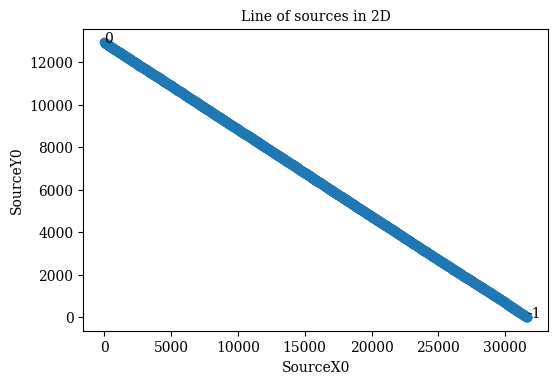

In [25]:
nsrc = len(th.SourceX0.unique())
xsrc = th.SourceX0.unique()
ysrc = th.SourceY0.unique()
print(f'nsrc = {nsrc}')
plt.figure(); plt.scatter(xsrc, ysrc); plt.title('Line of sources in 2D'); plt.ylabel('SourceY0'); plt.xlabel('SourceX0');
plt.text(xsrc[0], ysrc[0], '0'); plt.text(xsrc[-1], ysrc[-1], '-1');

In [26]:
xsrc_raw = np.array(sorted(th.SourceX0.unique()))
ysrc_raw = np.array(sorted(th.SourceY0.unique()))
rsrc_raw = np.sqrt(xsrc_raw ** 2 + ysrc_raw ** 2)
print(f'xsrc_raw ({len(xsrc_raw)})\n\t{xsrc_raw.min()} m\t{xsrc_raw.max()} m')
print(f'ysrc_raw ({len(ysrc_raw)})\n\t{ysrc_raw.min()} m\t{ysrc_raw.max()} m')
print(f'rsrc_raw ({len(rsrc_raw)})\n\t{rsrc_raw.min()} m\t{rsrc_raw.max()} m')

dsrc_raw = np.round(np.mean(rsrc_raw[1:] - rsrc_raw[:-1]), 2)

print('\nSource spacing: {} m'.format(dsrc_raw))

xsrc_raw (1824)
	0 m	31638 m
ysrc_raw (1824)
	0 m	12936 m
rsrc_raw (1824)
	0.0 m	34180.44967521638 m

Source spacing: 18.75 m


In [27]:
# rsrc_raw[53] / (dx)

In [28]:
every_nth_src_spacing = [dsrc_raw * i for i in [4, 8]]
# Suitable grid spacings to have sources placed in grid nodes
print('Suitable spacing between sources for grid step of 25 m:\t' + ', '.join([str(np.round(s)) for s in every_nth_src_spacing]))

Suitable spacing between sources for grid step of 25 m:	75.0, 150.0


In [29]:
th.keys()

Index(['TRACE_SEQUENCE_FILE', 'TraceNumber', 'offset', 'SourceWaterDepth',
       'GroupWaterDepth', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'MuteTimeStart', 'MuteTimeEND', 'TRACE_SAMPLE_COUNT',
       'TRACE_SAMPLE_INTERVAL', 'SourceX0', 'SourceY0', 'SourceX1D', 'GroupX0',
       'GroupY0', 'GroupX1D', 'ReceiverX1D'],
      dtype='object')

In [30]:
# Remove redundant columns
drop_list = ['SourceX', 'SourceY',
             'SourceX0', 'SourceY0',
             'GroupX', 'GroupY',
             'GroupX0', 'GroupY0',
             'MuteTimeStart',
             'MuteTimeEND']
print(drop_list)
th = th.drop(drop_list, axis=1, errors='ignore')
th.head()

['SourceX', 'SourceY', 'SourceX0', 'SourceY0', 'GroupX', 'GroupY', 'GroupX0', 'GroupY0', 'MuteTimeStart', 'MuteTimeEND']


,TRACE_SEQUENCE_FILE,TraceNumber,offset,SourceWaterDepth,GroupWaterDepth,TRACE_SAMPLE_COUNT,TRACE_SAMPLE_INTERVAL,SourceX1D,GroupX1D,ReceiverX1D
1,0,0,169,5.0,8.0,3526,2000,0.0,0.000000,175.000000
2,1,1,181,5.0,8.1,3526,2000,0.0,12.083046,187.083046
3,2,2,194,5.0,8.3,3526,2000,0.0,25.079872,200.079872
4,3,3,206,5.0,8.5,3526,2000,0.0,37.161808,212.161808
5,4,4,219,5.0,8.7,3526,2000,0.0,50.159745,225.159745


In [31]:
# Group shots
th['SHOT_ID'] = th.groupby('SourceX1D').ngroup()
print(f'Assign SHOT_IDs for {th.SHOT_ID.nunique()} shots')

Assign SHOT_IDs for 1824 shots


# Replicate Mahesh's setup
Keep first 576 shots

In [32]:
# Select shots, about like in Mahesh's paper
# https://academic.oup.com/gji/article/210/3/1581/3829893?login=true

# Old
# shot_id_min = 60
# shot_id_max = 680}')

# shot_id_min = 60
# n_selected_shots = 64
# njump_src = 8 # because spacing between sources is 18.75 and 6 maps well on grid nodes spaced by 25 m

# if 'shot_id_min' not in globals():
#     shot_id_min = 60
#     n_selected_shots = 80
#     njump_src = 8

# shot_id_min = 60
# n_selected_shots = 60
# njump_src = 8 # because spacing between sources is 18.75 and 6 maps well on grid nodes spaced by 25 m

shot_id_min = 20
n_selected_shots = 95
njump_src = 8

# n_selected_shots = 60
# njump_src = 11
### this parameters are loaded from fwi_marm.ipynb
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src
print(f'Select {n_selected_shots} shots in range {shot_id_min}..{shot_id_max}')
th = th.drop(th[th['SHOT_ID'] < shot_id_min].index)
th = th.drop(th[th['SHOT_ID'] >= shot_id_max].index)

nsrc = th.SHOT_ID.nunique()
src_id_min = th.SHOT_ID.unique().min()
src_id_max = th.SHOT_ID.unique().max()
print(f'Remaining shots - first {nsrc}, {src_id_min}..{src_id_max}')

Select 95 shots in range 20..772
Remaining shots - first 752, 20..771


Zero-offset section (752, 3526)


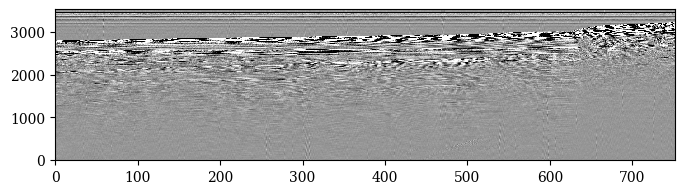

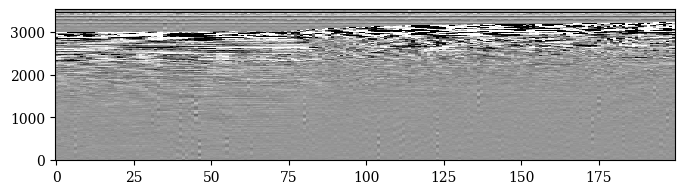

In [33]:
# Plot zero-offset section
shot_ids = natsorted(th.SHOT_ID.unique())
zero_offset = np.zeros((len(shot_ids), dNT))
print(f'Zero-offset section {zero_offset.shape}')
with segyio.open(filename, ignore_geometry=True) as f:
    for ishot, shot_id in enumerate(shot_ids):
        _shot = th[th.SHOT_ID == shot_id]
        id_min = _shot.TRACE_SEQUENCE_FILE.min()
        zero_offset[ishot, :] = f.trace.raw[id_min:id_min + 1]
vis.plot_shot(zero_offset, pclip=0.01, figsize=(8,2), colorbar=False)
vis.plot_shot(zero_offset[-200:, :], pclip=0.01, figsize=(8,2), colorbar=False)

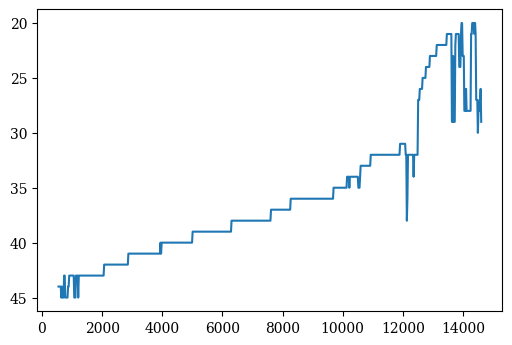

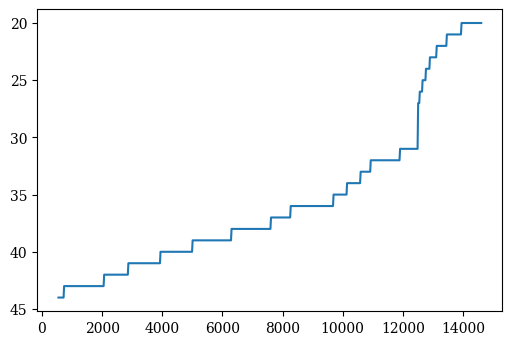

In [34]:
wb = []
xb = []
with segyio.open(filename, ignore_geometry=True) as f:
    for ishot, shot_id in enumerate(range(src_id_min, src_id_max)):
        _shot = th[th.SHOT_ID == shot_id]
        id_min = _shot.TRACE_SEQUENCE_FILE.min()
        s = f.trace.raw[id_min:id_min + 10]
        time_idx_start = 350 # 450
        s = s[:, time_idx_start:800]
        amax = np.argmax(np.sum(s, 0))
        wb.append(amax + time_idx_start)
        xb.append(_shot['ReceiverX1D'][0:1])
wb_p = [int(np.floor(_wb * 0.002 / 2 * np.min(vp_cgg) / dx)) for _wb in wb]
# plt.figure(); plt.plot(xb, wb_p); plt.gca().invert_yaxis()

# sort water bottom
wb_reverse = copy.copy(wb_p)
plt.figure(); plt.plot(xb, wb_reverse); plt.gca().invert_yaxis()

new_bottom = [wb_reverse[0]]
for ipoint in range(1, len(wb_reverse)):
    this_point = wb_reverse[ipoint]

    if this_point > new_bottom[-1]:
        new_bottom.append(new_bottom[-1])
    else:
        new_bottom.append(this_point)
plt.figure(); plt.plot(xb, new_bottom); plt.gca().invert_yaxis();
wb_p = copy.copy(new_bottom)
    

20 44 751
548.8462250712182 14608.908167921812 751
(152, 600)


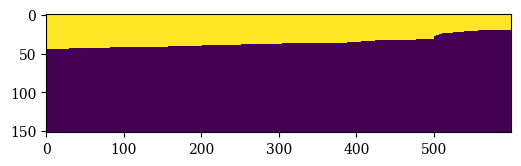

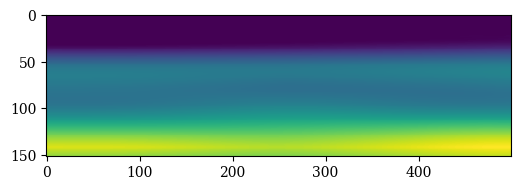

In [35]:
print(np.min(wb_p), np.max(wb_p), len(wb_p))
print(np.min(xb), np.max(xb), len(xb))

xbb = np.array([_xb.to_list()[0] for _xb in xb])

# for every pixel along OX of velocity model
# xv = [i*dx for i in range(nx0 - nexp)]
xv = [i*dx for i in range(nx0)]
# find nearest known water depth
# wb_taper = np.zeros_like(taper0)
wb_taper = np.zeros_like(vp)
wb_args = []
for ix, x in enumerate(xv):
    arg = np.argmin(np.abs(xbb - x))
    wb_args.append(wb_p[arg]-1)
    wb_taper[-wb_p[arg]-1:, ix] = 1.
plt.figure(); plt.imshow(np.flip(wb_taper, 0));
plt.figure(); plt.imshow(np.flip(vp_cgg, 0));
print(wb_taper.shape)
# vis.plot_model(taper0 - wb_taper.astype(np.float), title='Diff water layer prev vs my')

In [36]:
log = vp_cgg[:, 0:1]
print(log.shape)
vmin = np.min(log)
vmax = np.max(log)
vps = []
for wb in wb_args:
    fun = vmin * np.ones_like(log)
    fun[wb:, :] = 450 + fun[wb:, :] + 12 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    vps.append(fun[::-1, :])
vp = np.concatenate(vps, -1)
print(vp.shape)

(152, 1)
(152, 600)


(152, 600)
(152, 500)
(152, 600)
Well-log from 10500 maps into ix: 420


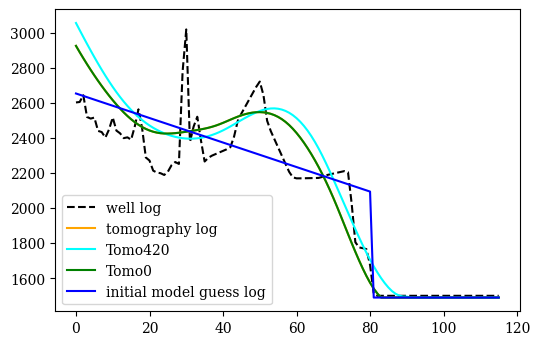

In [37]:
# actual location is 10500 m. The
wlog = lvp[:, 0:1]

vmin = np.min(log)
vmax = np.max(log)
vps = []
print(vp.shape)
print(vp_cgg.shape)
for i in range(vp.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i])
    fun = vmin * np.ones_like(log)
#     fun[wb:, :] = 575 + fun[wb:, :] + 8 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun[wb:, :] = 605 + fun[wb:, :] + 7 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
#     vps.append(np.maximum(fun, log))
    vps.append(fun)
vp = np.concatenate(vps, -1)

print(vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); 
plt.plot(wlog, 'k--', label='well log');  #well log
plt.plot(log[-len(wlog):], 'orange', label='tomography log');   #tomography log

plt.plot(vp_cgg[-len(wlog):,420], 'cyan', label='Tomo420')
plt.plot(vp_cgg[-len(wlog):,0], 'g', label='Tomo0')

plt.plot(vp[-len(wlog):, log_idx], 'b',label='initial model guess log')     # initial model guess log
# plt.legend(['well log','tomography log','initial model guess log'])
plt.legend()

(152, 600)
(152, 500)
(152, 600)
Well-log from 10500 maps into ix: 420


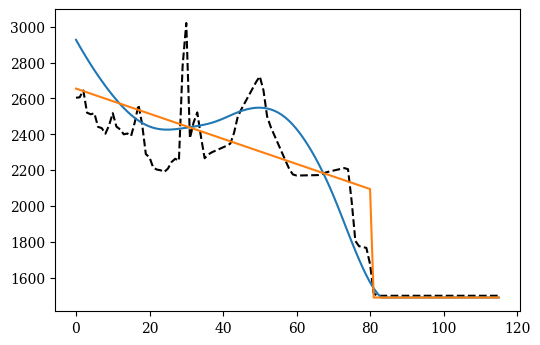

In [38]:
vps = []
print(vp.shape)
print(vp_cgg.shape)
for i in range(vp.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i])
    fun = vmin * np.ones_like(log)
#     fun[wb:, :] = 575 + fun[wb:, :] + 8 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun[wb:, :] = 605 + fun[wb:, :] + 7 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
#     vps.append(np.maximum(fun, log))
    vps.append(fun)
vp = np.concatenate(vps, -1)

print(vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(vp[-len(wlog):, log_idx])

(152, 600)
(152, 600)
(152, 500)


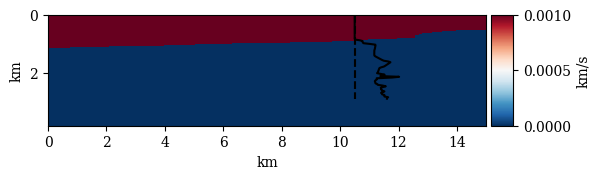

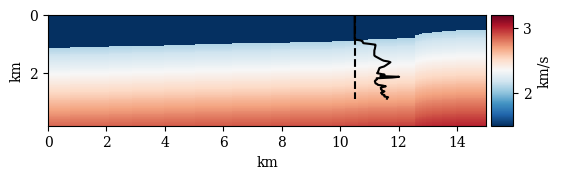

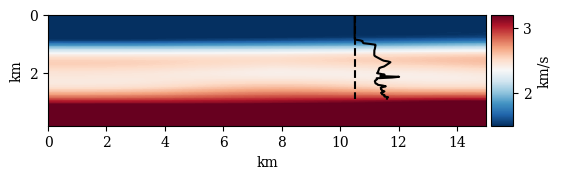

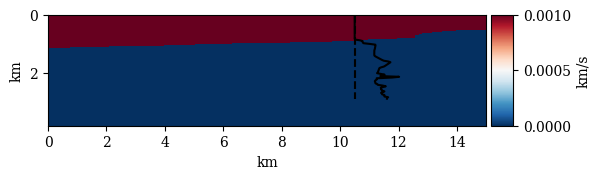

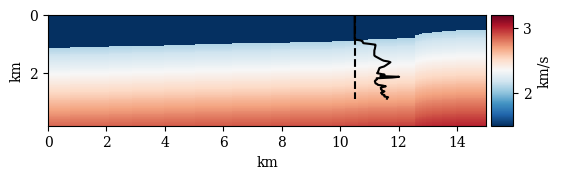

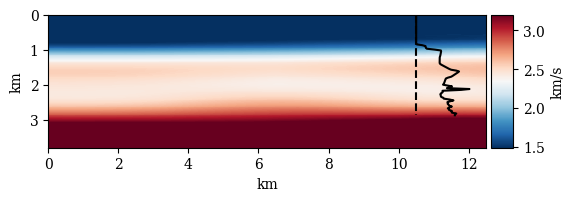

In [39]:
def plot_log_model(mm, dx, nx0=None, nz0=None, _src=None, title='', log=None, log_location=None, cmap='RdBu_r', axis=True, cax_label='km/s', **kwargs):
    v = mm.copy() / 1000
    plt.figure(); ax = plt.gca()
    nz, nx = mm.shape[-2:]
    if _src is not None:
        nx0=nx
        map_src = _src.x / dx < nx0
        plt.scatter(_src.x[map_src]/1000, _src.y[map_src]/1000, 1, color='w'); 
    im = ax.imshow(v[:,:nx0], cmap=cmap, extent=[0, nx0 * dx / 1000 if nx0 else nx * dx / 1000, 
                    0, nz0 * dx/1000 if nz0 else nz * dx / 1000], origin='upper', **kwargs);
    divider = make_axes_locatable(ax); 
    cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax); cbar.set_label(cax_label);
    if axis:
        ax.set_xlabel('km'); ax.set_ylabel('km'); ax.set_title(title);
    else:
        ax.axis('off')
    ax.invert_yaxis();
    if log is not None:
        vh = log_location * np.ones_like(log) / 1000 
        ax.plot(vh, np.arange(len(log))*dx/1000, 'k--')
        ax.plot(vh + (log[::-1] - min(log)) / 1000, np.arange(len(log))*dx/1000, 'k')
limits_vp2 = {'vmin': 1490 , 'vmax': 3200 }
limits_vp3 = {'vmin': 1490/1000 , 'vmax': 3200/1000 }
nz1,nx1=vp.shape
print(wb_taper.shape)
print(vp.shape)
print(vp_cgg.shape)

vis.plot_log_model(wb_taper, dx, nx0, nz0,log=wlog, log_location=log_loc)
vis.plot_log_model(vp, dx, nx0,nz0,log=wlog, log_location=log_loc,**limits_vp3)
vis.plot_log_model(vp_cgg, dx, nx0, nz0,log=wlog, log_location=log_loc,**limits_vp3)
vis.plot_log_model(wb_taper, dx,log=wlog, log_location=log_loc)
vis.plot_log_model(vp, dx,log=wlog, log_location=log_loc,**limits_vp3)
vis.plot_log_model(vp_cgg,dx,log=wlog, log_location=log_loc,**limits_vp3)

25.0
Save /home/plotnips/Dropbox/Apps/Overleaf/draft_Geophysics_FWI_init_model_prediction/paper_geophysics/Fig/logvsinit.png


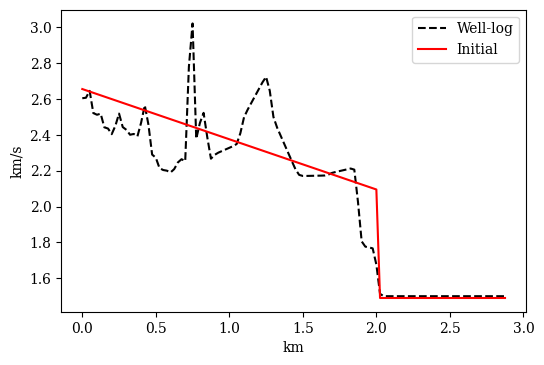

In [40]:
print(dx)
plt.figure(); 
xvec = np.arange(len(wlog)) * dx / 1000
plt.plot(xvec, wlog / 1000, 'k--');
plt.plot(xvec, vp[-len(wlog):, log_idx] / 1000, 'r'); 
plt.legend(['Well-log', 'Initial']); plt.ylabel('km/s'); plt.xlabel('km');
vis.savefig('logvsinit.png')

(152, 600) (152, 600)
(152, 600)
(152, 600)
(152, 600)


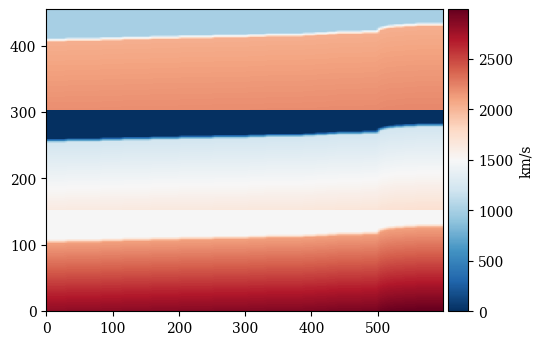

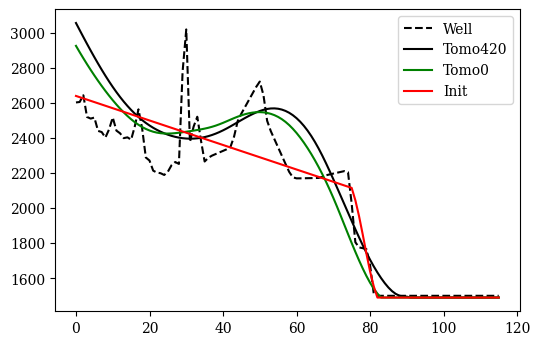

In [41]:
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

print(wb_taper.shape, vp.shape)
# vp = extend(np.where(wb_taper, np.min(vp_cgg), vp), 0, nexp)
# vs = extend(np.where(wb_taper, 0, vs), 0, nexp)
# rho = extend(np.where(wb_taper, 1000, rho), 0, nexp)
vp = np.where(wb_taper, np.min(vp_cgg), vp)
vs = np.where(wb_taper, 0, vs)
rho = np.where(wb_taper, 1000, rho)

# s, w = 2, 5
s, w = 3, 7
sigma_truncate = {'sigma': s, 'truncate': (((w - 1)/2)-0.5)/s}
vp = gaussian_filter(vp.copy(), **sigma_truncate)
vs = gaussian_filter(vs.copy(), **sigma_truncate)
rho = gaussian_filter(rho.copy(), **sigma_truncate)

print(vp.shape)
vshift = 2
vp = extend(vp, vshift, 0)[vshift:]
vs = extend(vs, vshift, 0)[vshift:]
rho = extend(rho, vshift, 0)[vshift:]
print(vp.shape)

model = api.Model(vp, vs, rho, dx)
print(vp.shape)
vis.plot_model(np.concatenate((vp, vs, rho), 0))

fig = plt.figure(); 
plt.plot(wlog, 'k--', label='Well')
# vp_cgg[:, 0:1]
plt.plot(vp_cgg[-len(wlog):,420], 'k', label='Tomo420')
plt.plot(vp_cgg[-len(wlog):,0], 'g', label='Tomo0')


# plt.plot(log[-len(wlog):], 'g', label='Tomo0')
plt.plot(vp[-len(wlog):, log_idx], 'r', label='Init')
# plt.plot(vp_[-len(wlog):, log_idx], 'b', label='New init')
plt.legend()
# plt.legend(['Well-log', 'Initial']);
# fig.colorbar()

In [42]:
print(np.min(vp))

1490.0


# Select shots for inversion

In [43]:
# n_selected_shots = 56
# n_selected_shots = 112
print(f'Select {n_selected_shots} shots from {src_id_min} to {src_id_max}')

Select 95 shots from 20 to 771


In [44]:
print(src_id_min, src_id_max, n_selected_shots, njump_src)
selected_ids = [int(np.floor(x)) for x in np.linspace(src_id_min, src_id_max, n_selected_shots)]

ths = th.loc[th['SHOT_ID'].isin(selected_ids)]
print(f'Shots selected {len(selected_ids)}:\n\t{selected_ids[0]}..{selected_ids[-1]}\n\t{selected_ids}')

20 771 95 8
Shots selected 95:
	20..771
	[20, 27, 35, 43, 51, 59, 67, 75, 83, 91, 99, 107, 115, 123, 131, 139, 147, 155, 163, 171, 179, 187, 195, 203, 211, 219, 227, 235, 243, 251, 259, 267, 275, 283, 291, 299, 307, 315, 323, 331, 339, 347, 355, 363, 371, 379, 387, 395, 403, 411, 419, 427, 435, 443, 451, 459, 467, 475, 483, 491, 499, 507, 515, 523, 531, 539, 547, 555, 563, 571, 579, 587, 595, 603, 611, 619, 627, 635, 643, 651, 659, 667, 675, 683, 691, 699, 707, 715, 723, 731, 739, 747, 755, 763, 771]


In [45]:
actual_shot_locations = np.concatenate([ths[ths.SHOT_ID == shot_id].SourceX1D.unique() for shot_id in selected_ids])
# print(actual_shot_locations)

In [46]:
# print(actual_shot_locations[1:] - actual_shot_locations[:-1])

In [47]:
# print(src_id_min, src_id_min + (n_selected_shots-1) * njump_src, n_selected_shots, njump_src)
# selected_ids = [int(np.floor(x)) for x in np.linspace(src_id_min, src_id_min + (n_selected_shots-1) * njump_src, n_selected_shots)]

resulting_src_spacings = [a-b for a,b in zip(selected_ids[1:], selected_ids[:-1])]
print(f'Grid nodes between sources:\n\tmin={min(resulting_src_spacings)} == max={max(resulting_src_spacings)}?')

Grid nodes between sources:
	min=7 == max=8?


Look at shot 20


Text(0.5, 1.0, 'Streamer')

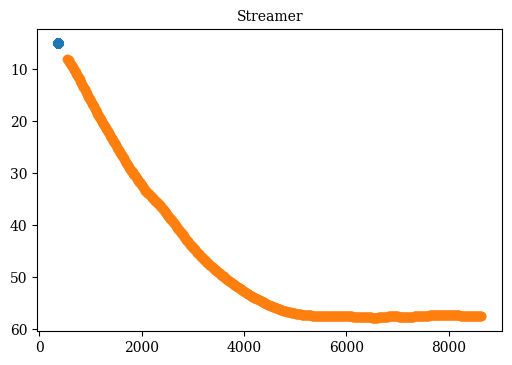

In [48]:
# take 1 shot and visualize streamer
shot_id = selected_ids[0]
print(f'Look at shot {shot_id}')
shot = ths[ths.SHOT_ID == shot_id]

plt.figure(); plt.gca().invert_yaxis();
plt.scatter(shot.SourceX1D, shot.SourceWaterDepth); 
plt.scatter(shot.ReceiverX1D, shot.GroupWaterDepth);
plt.title('Streamer')

In [49]:
# Read data for this shot
with segyio.open(filename, ignore_geometry=True) as f:
    id_min = shot.TRACE_SEQUENCE_FILE.min()
    id_max = shot.TRACE_SEQUENCE_FILE.max() + 1
    print(f'Read traces {id_min}:{id_max}')
    shot_data = f.trace.raw[id_min:id_max]
print(shot_data.shape)

Read traces 12960:13608
(648, 3526)


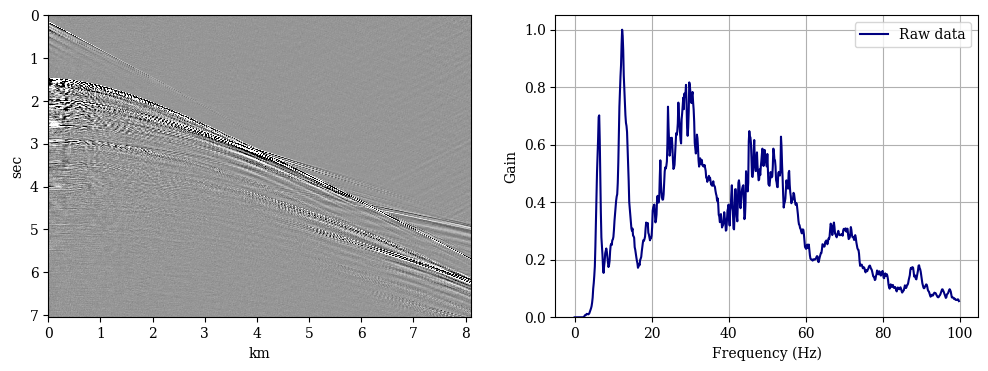

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
vis.plot_shot(ld.bandpass(shot_data, fs=1/dDT, fhi=15, btype='low'), dt=dDT, dx=12.5, pclip=0.05, colorbar=False, ax=ax[0]);
# vis.plot_shot(shot_data,dt=dDT, dx=12.5, pclip=0.05, colorbar=False, ax=ax[0]);
# vis.savefig('raw_shot.png')

vis.plot_spectra_dictlist([{'data': shot_data, 'line': 'navy', 'label': 'Raw data'}], dt=dDT, fmax=100., norm=True, ax=ax[1])
# vis.savefig('raw_spec.png')

# Source wavelet
Thanks Mahesh Kalita and Abdullah Alalai!

In [51]:
wavelets, opts = ld.load_hh(os.path.join(root_field, 'kwlt10p0.hh'))
print(f'Load wavelet for unknown set of shots: {wavelets.shape}.\nParameters: {opts}')

Load wavelet for unknown set of shots: (704, 7052).
Parameters: {'n1': 7052, 'd1': 0.001, 'o1': 0, 'n2': 704, 'd2': 1, 'o2': 0}


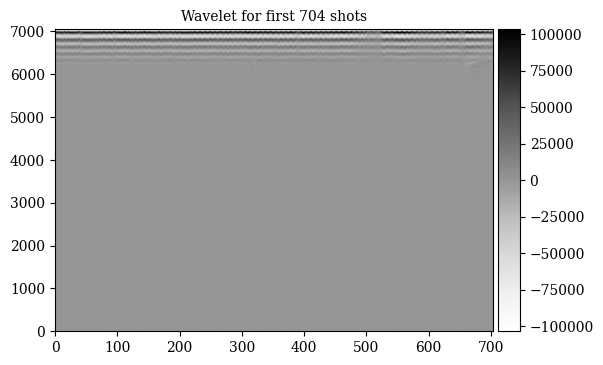

In [52]:
vis.plot_shot(wavelets, title='Wavelet for first 704 shots');

dt_wavelet= 0.001


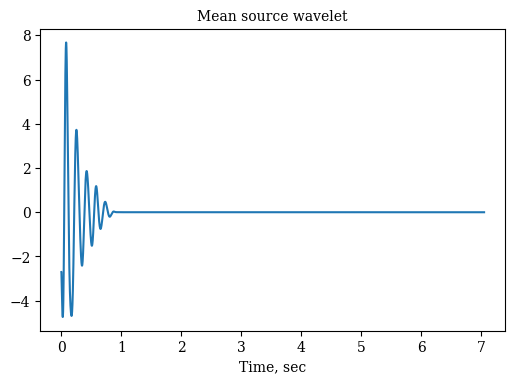

In [53]:
def plot_wavelet(x, y, title=''):
    plt.figure(); plt.plot(x, y); 
    plt.xlabel('Time, sec'); plt.title(title);

wavelet = np.mean(wavelets, axis=0, keepdims=True) / 1e4
nt_wavelet = opts['n1']
dt_wavelet = opts['d1']
print('dt_wavelet=',dt_wavelet)
ax_t = np.arange(0, nt_wavelet)[..., np.newaxis]*dt_wavelet
plot_wavelet(ax_t, wavelet.T, 'Mean source wavelet')

Save /home/plotnips/Dropbox/Apps/Overleaf/draft_Geophysics_FWI_init_model_prediction/paper_geophysics/Fig/wavelet.png


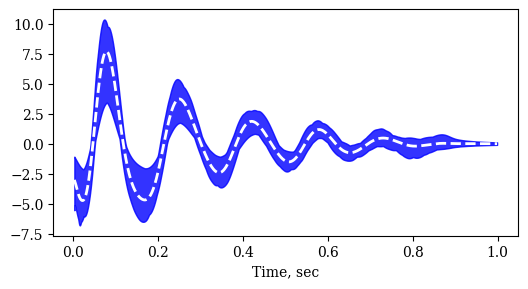

In [54]:
_nt = 1000 # time steps to zoom in
_ws = wavelets[:, 4:_nt] / 1e4
_ax_t = ax_t[4:_nt, :].squeeze()
plt.figure(figsize=(6, 3)); plt.fill_between(_ax_t, np.min(_ws, axis=0), np.max(_ws, axis=0), color='b', alpha=0.8);
plt.plot(_ax_t, np.mean(_ws, axis=0), 'w--', lw=2); 
# plt.plot(_ax_t, wavelet, 'g--', lw=2); 
# plt.title('Wavelet span over a set of offsets'); 
plt.xlabel('Time, sec');
vis.savefig('wavelet.png')

In [55]:
fhi = 10.0
par_bp = {'fhi': fhi, 'btype': 'low', 'order': 4}
par_mut = {'k': 3.5, 'b': -80, 'r': 65}

In [56]:
# !!! NOTE dx/2 added so sources are not on free surface!

rec_ = api.Receivers()

xsrc, ysrc = [], []
selected_wavelets = []
selected_shot_ids = []
data = []
with segyio.open(filename, ignore_geometry=True) as f:
    for shot_id in ths.SHOT_ID.unique():
        clear_output()
        print(shot_id)
        shot = th[th.SHOT_ID == shot_id]

        id_min = shot.TRACE_SEQUENCE_FILE.min()
        id_max = shot.TRACE_SEQUENCE_FILE.max() + 1
        print(f'Read traces {id_min}:{id_max}')
        _shot_data = f.trace.raw[id_min:id_max]
        data.append(np.expand_dims(_shot_data, 0))

        # sources
        xsrc.append(shot.SourceX1D.unique()[0])
        ysrc.append(shot.SourceWaterDepth.unique()[0] + ndeeper * dx)

        # receivers
        xrec = np.round(shot.ReceiverX1D.to_numpy(), 1)
        yrec = np.round(shot.GroupWaterDepth.to_numpy(), 1) + ndeeper * dx
        rec_.add(xrec, yrec)

        selected_wavelets.append(wavelets[shot_id:shot_id+1, :])
        selected_shot_ids.append(shot_id)

src_ = api.Sources(np.array(xsrc), np.array(ysrc))
print(f'Selected shot ids: {selected_shot_ids[0]}..{selected_shot_ids[-1]}, ({len(selected_shot_ids)} items)')
print(f'Will later save all sources into {len(src_)} file')
print(f'Will later save receivers into {len(rec_)} files')
print(f'Will later save wavelets into {len(selected_wavelets)} files')

data = np.concatenate(data, 0)
print(f'Data cube: {data.shape}')

771
Read traces 499608:500256
Selected shot ids: 20..771, (95 items)
Will later save all sources into 95 file
Will later save receivers into 95 files
Will later save wavelets into 95 files
Data cube: (95, 648, 3526)


In [57]:
print(src_.x)

[  374.62114196   506.32005688   656.40307738   806.62568766
   956.07792569  1106.24138415  1256.26191537  1406.32748675
  1555.85346354  1706.85031564  1856.31893811  2005.79011863
  2155.86015316  2306.2562737   2456.275636    2605.58342795
  2755.86719564  2906.48120586  3056.11681714  3206.30519446
  3356.70791103  3505.8456897   3656.29019636  3806.52334815
  3955.83126536  4106.02118845  4255.6688076   4405.86972118
  4556.10206207  4705.4413183   4855.92555544  5005.99260886
  5155.80139261  5305.78900824  5455.2676378   5606.08330298
  5755.42961038  5906.25304233  6056.06448116  6204.95608365
  6355.73756538  6505.45963019  6655.18895299  6805.80142232
  6956.20140594  7105.844707    7254.94259109  7405.72319223
  7555.57813804  7705.47292514  7855.20362562  8005.65025466
  8155.50372448  8305.69082015  8455.50294187  8605.18878352
  8755.46486487  8905.91045318  9055.218385    9206.16429356
  9355.26055222  9505.87255332  9654.96929047  9805.03447215
  9954.93329963 10105.00

In [58]:
dsrc_raw = np.mean(np.array(xsrc[1:]) - np.array(xsrc[:-1]))
print(f'Raw distance between selected sources: {dsrc_raw}')

Raw distance between selected sources: 149.78480884102134


## Interpolation for near-offset

(704, 7052)


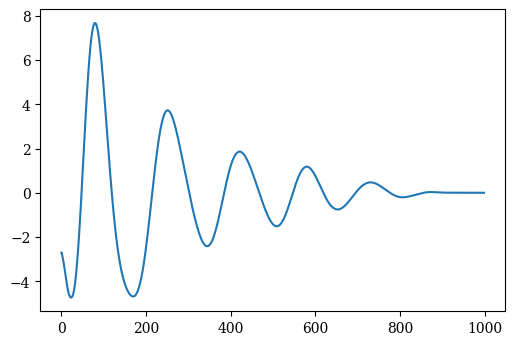

In [59]:
print(wavelets.shape)
wavelet = np.mean(wavelets, 0) / 1e4
plt.figure(); plt.plot(list(wavelet)[:1000])

(1, 7052)


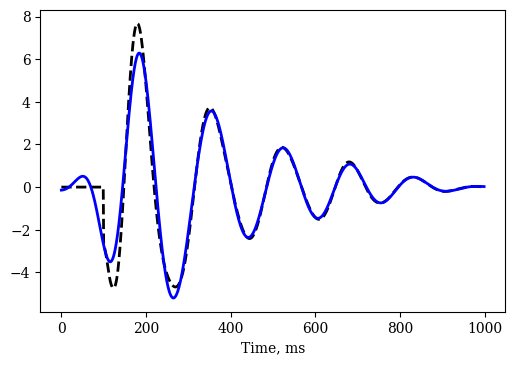

In [60]:
wavelet = list(wavelet)
nt0 = len(wavelet)
nt_push = 100
for _ in range(nt_push):
    wavelet.insert(0, 0)
wavelet = np.array(wavelet)
bp = ld.bandpass(wavelet[np.newaxis,...], fs=1./dt_wavelet, **par_bp)
plt.figure(); 
plt.plot(list(wavelet)[:1000], 'k--', lw=2)
plt.plot(list(bp[0,...])[:1000], 'b', lw=2)
plt.xlabel('Time, ms')
bp = bp[:,:nt0]
print(bp.shape)

(95, 7052)
wls_tmp= (95, 3526)
bpw= (95, 7052)


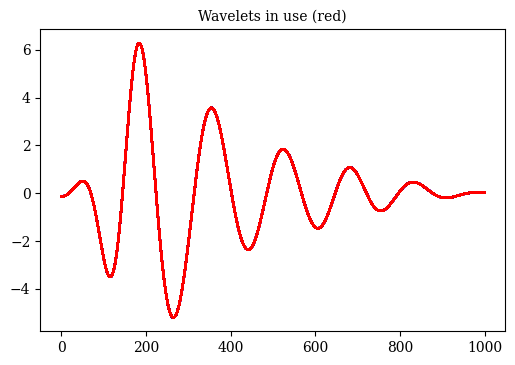

In [61]:
src_wavelets = np.repeat(bp, len(src_), 0)
# src_wavelets = np.repeat(np.mean(wavelets,0, keepdims=True), len(src_), 0)
# src_wavelets = np.repeat(wavelet, len(src_), 0)
# src_wavelets = np.concatenate(selected_wavelets, 0) / 1e4
print(src_wavelets.shape)
bpw = copy.deepcopy(src_wavelets)
wls_tmp = bpw[:, ::2]
print('wls_tmp=',wls_tmp.shape)
print('bpw=',bpw.shape)
# bpw = ld.bandpass(src_wavelets, fs=1./dt_wavelet, **par_bp)

plt.figure(); 
plt.plot(src_wavelets[:,:_nt].T, 'b')
plt.plot(bpw[:, :_nt].T, 'r'); plt.title('Wavelets in use (red)');

# Preprocessing
1. Deconvolve with source wavelet
2. Bandpass < 10 Hz
3. Mute before first break

In [62]:
nsrc, nrec, nt = data.shape
nt_wavelet = src_wavelets.shape[-1]
skip_nt_wavelet = nt_wavelet // nt
skip_rec = 2
limit_nt = 3000
ext_nt = 100
data_p = np.zeros((nsrc, nrec // skip_rec, limit_nt))
data_p_ext = np.zeros((nsrc, nrec // skip_rec, limit_nt + ext_nt))
# for ishot in range(2):
for ishot in range(nsrc):
    clear_output()
    print(f'{ishot+1}/{nsrc}')
    shot = data[ishot, ...].copy()
    print(f'Before prep:\t{data.shape}')
    shot = ld.bandpass(shot, fs=1./dDT, **par_bp)
#     tmp = np.zeros((shot.shape[0], shot.shape[1] + int(nt_push // 2)))
#     tmp[:, int(nt_push // 2):] = shot.copy()
#     shot = ld.bandpass(tmp, fs=1./dDT, **par_bp)
#     shot = ld.mutter(shot, 3.0, -80, 15)
#     shot = ld.mutter(shot, 3.0, -80)
    shot = shot[::skip_rec, :]
    data_p_ext[ishot, ...] = shot[:, :limit_nt + ext_nt]
    data_p[ishot, ...] = shot[:, :limit_nt]
print(f'Data cube:\t{data_p.shape}\nExtended cube:\t{data_p_ext.shape}')

95/95
Before prep:	(95, 648, 3526)
Data cube:	(95, 324, 3000)
Extended cube:	(95, 324, 3100)


In [63]:
# Push field data 50 samples in time to match synthetic wavelet
def pad_nt(dat, npush=0):
    old_shape = list(dat.shape)
    lnt = old_shape[-1]
    old_shape[-1] += int(npush // 2)
    tmp = np.zeros(old_shape)
    tmp[..., int(npush // 2):] = dat
    dat = tmp[..., :lnt]
    print(old_shape, dat.shape)
    return dat

data_p = pad_nt(data_p, nt_push)
data_p_ext = pad_nt(data_p_ext, nt_push)

[95, 324, 3050] (95, 324, 3000)
[95, 324, 3150] (95, 324, 3100)


Before this cell we have EXACT location of sources, directly from field data. Here, **we take the mean spacing between sources**

In [64]:
# rec = copy.deepcopy(rec_)
# for isrc in range(nsrc):
#     rec[isrc].x = rec[isrc].x[::skip_rec]
#     rec[isrc].y = rec[isrc].y[::skip_rec]
# rec = api.Receivers(rec_[0].x[::skip_rec], 75 * np.ones_like(rec_[0].y[::skip_rec]))
# print(f'{len(rec)} streamers with {len(rec[0])} hydrophones in each')
# print(rec)

print(dx)

dsrc = np.round(np.mean(src_.x[1:] - src_.x[:-1]) / dx) * dx
print(f'Assume even average spacing between sources\n {dsrc} m ~ {int(dsrc / dx)} grid nodes')
# dsrc = dx * njump_src
# print(f'dsrc:\t{dsrc} m')
src_x0 = np.round(src_.x[0] / dx) * dx
src_x1 = np.round(src_.x[-1] / dx) * dx
print(f'First source:\t{src_x0} m\nLast source:\t{src_x1} m')

25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	375.0 m
Last source:	14450.0 m


In [65]:
print(dsrc)
src_offsets = src_x0 + np.arange(nsrc) * dsrc
# print(src_offsets)
src_depth = np.round(np.mean(src_.y) / dx) * dx
src = api.Sources(src_offsets, src_depth * np.squeeze(np.ones((nsrc, 1))))
print(src)

150.0
name:	
x	(95,):	min: 375.0	max: 14475.0
y	(95,):	min: 50.0	max: 50.0
wavelets:	None
z	(95,):	min: 0.0	max: 0.0
nshot:	95
td	(95,):	min: 0.0	max: 0.0
fc	(95,):	min: 8.0	max: 8.0
amp	(95,):	min: 1.0	max: 1.0
angle	(95,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(95,):	min: 1.0	max: 1.0


In [66]:
drec = np.round(np.mean(rec_[0].x[1:] - rec_[0].x[:-1]) / dx) * dx
print(f'drec:\t{drec} m')
rec_x0 = np.floor(rec_[0].x[0] / dx) * dx
rec_depth = np.round(np.mean(rec_[0].y) / dx) * dx
rec = api.Receivers(rec_x0 + np.arange(int(nrec / skip_rec)) * drec, rec_depth * np.ones_like(rec_[0].y[::skip_rec]))
print(rec)

drec:	25.0 m
x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [67]:
log = model_log.vp[:, log_idx]
log_location = 420*dx

x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]
(152, 600)
(152, 600)
(152, 500)
12500.0


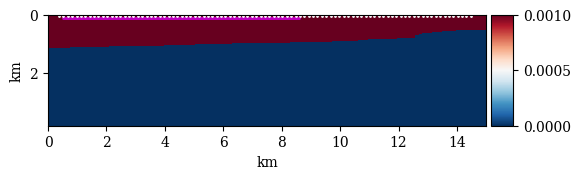

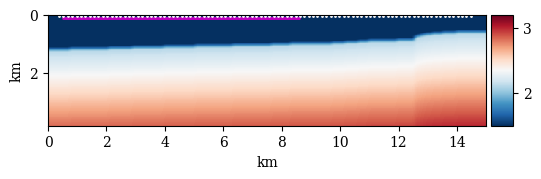

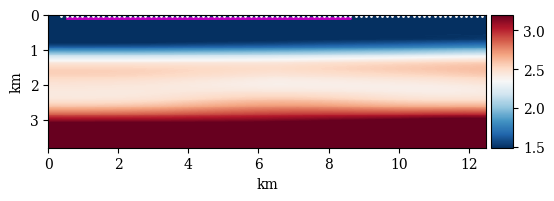

In [68]:
# print(src)
print(rec)
print(wb_taper.shape)
print(vp.shape)
print(vp_cgg.shape)
print(500*dx)
vis.plot_acquisition(wb_taper,dx,src,rec)
vis.plot_acquisition(vp, dx,src,rec,**limits_vp3)
vis.plot_acquisition(vp_cgg,dx,src,rec,**limits_vp3)

In [69]:
# acq_data = {'src':src,'rec':rec,'wavelet':bpw,'src_x0':src_x0,'rec_x0':rec_x0,'dsrc':dsrc,'drec':drec,'dDT':dDT}
# print(os.getcwd())
# with open(os.path.join('acq_data_parameters.pkl'),'rb') as input:
#     d2=pickle.load(input)
# # print(d2)
# print(src)
# print(d2['src'])
# print(os.getcwd())
# with open(os.path.join('acq_data_parameters_cgg_wider.pkl'), 'wb+') as output:
#     pickle.dump(acq_data,output,protocol=4)
# # with open(os.path.join('acq_data_parameters.pkl'), 'wb+') as output:
# #     pickle.dump(acq_data,output,protocol=4)